In [ ]:
# 08_modelisation_ml.ipynb
# Objectif : prédire la consommation réelle (kWh/an/logement) et comparer au DPE.

# from google.colab import drive
# drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np

# base_path = "/content/drive/MyDrive/Hackathon_2025/datasets/processed"
base_path = "C:/Users/hp_st/Desktop/Hackathon/processed"
dbz_path = os.path.join(base_path, "dbz.csv")

df = pd.read_csv(dbz_path)

print("Shape initial dbz :", df.shape)
df.head()

Shape initial dbz : (42702, 36)


,address_ban,latitude,longitude,ban_id,numero_de_voie,type_de_voie,libelle_de_voie,code_commune,nom_commune,nombre_logements,...,periode_construction,annee_construction,date_etablissement_dpe,date_fin_validite_dpe,date_reception_dpe,date_visite_diagnostiqueur,date_modif_dpe,annee_dpe,annee_enedis,annee_dpe_matched
0,1 Allee Andre Crozillac 33610 Canéjan,44.750613,-0.643899,33090_3300_00001,1.0,ALLEE,ANDRE CROZILLAC,33090,CANEJAN,19,...,2013-2021,2013.0,2021-12-29,2031-12-28,2021-12-30,2021-12-29,2024-02-06,2024,2018,2024
1,1 Allee Antoine Portal 92140 Clamart,48.781671,2.228141,92023_0072_00001,1.0,ALLEE,ANTOINE PORTAL,92023,CLAMART,15,...,1948-1974,NaN,2022-06-21,2032-06-20,2022-06-26,2022-06-21,2024-02-06,2024,2018,2024
2,1 Allee Francois Broussais 93110 Rosny-sous-Bois,48.881048,2.488509,93064_3550_00001,1.0,ALLEE,FRANCOIS BROUSSAIS,93064,ROSNY-SOUS-BOIS,22,...,1948-1974,NaN,2022-05-10,2032-05-09,2022-05-11,2022-05-10,2024-02-06,2024,2018,2024
3,1 Allee Gaston Defferre 77200 Torcy,48.850174,2.651166,77468_0181_00001,1.0,ALLEE,GASTON DEFFERRE,77468,Torcy,16,...,1948-1974,1948.0,2021-11-04,2031-11-03,2021-11-05,2021-11-02,2024-02-06,2024,2019,2024
4,1 Allee Louis Tillet 91250 Saint-Germain-lès-C...,48.629569,2.491708,91553_0159_00001,1.0,ALLEE,LOUIS TILLET,91553,SAINT-GERMAIN-LES-CORBEIL,19,...,2006-2012,2006.0,2022-02-02,2032-02-01,2022-02-03,2022-02-02,2024-02-06,2024,2018,2024


Préparation minimale

In [ ]:
# Colonnes numériques clés
num_cols = [
    "conso_logement_kwh",
    "conso_5_usages_ef",
    "surface_habitable",
    "annee_construction",
    "annee_dpe",
    "annee_enedis",
    "annee_dpe_matched",
    "latitude",
    "longitude",
]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Conso réelle / théorique
df["conso_reelle_kwh"] = df["conso_logement_kwh"]
df["conso_dpe_kwh"] = df["conso_5_usages_ef"]

# Garder uniquement les lignes avec ces deux infos > 0
mask = (
    df["conso_reelle_kwh"].notna() &
    df["conso_dpe_kwh"].notna() &
    (df["conso_reelle_kwh"] > 0) &
    (df["conso_dpe_kwh"] > 0)
)
df = df[mask].copy()
print("Après filtre conso non nulle & >0 :", df.shape)

df[["conso_reelle_kwh", "conso_dpe_kwh"]].describe()

Après filtre conso non nulle & >0 : (42698, 38)


,conso_reelle_kwh,conso_dpe_kwh
count,42698.000000,4.269800e+04
mean,3177.515248,9.770093e+03
std,1835.338751,2.191832e+04
min,13.000000,3.076000e+02
25%,1798.885449,4.097800e+03
50%,2782.883333,6.761650e+03
75%,4167.746711,1.185740e+04
max,29669.692308,2.003137e+06


Filtrer sur toutes les valeurs extremes

In [ ]:
q1_reel, q99_reel = df["conso_reelle_kwh"].quantile([0.01, 0.99])
q1_dpe, q99_dpe = df["conso_dpe_kwh"].quantile([0.01, 0.99])

mask_reel = df["conso_reelle_kwh"].between(q1_reel, q99_reel)
mask_dpe = df["conso_dpe_kwh"].between(q1_dpe, q99_dpe)

df = df[mask_reel & mask_dpe].copy()
print("Après filtre 1–99% :", df.shape)

Après filtre 1–99% : (41019, 38)


Choix des features pour le modèle

In [ ]:
# Cible
y = df["conso_reelle_kwh"]

# Features utilisées pour les modèles
features = [
    "conso_dpe_kwh",
    "surface_habitable",
    "annee_construction",
    "etiquette_dpe",
    "type_batiment",
    "periode_construction",
    "code_region",
]

X = df[features].copy()
X.head()

# Supprimer les lignes qui ont au moins un NaN dans les features
mask_no_nan = X.notna().all(axis=1)

print("Lignes avant drop NaN :", X.shape[0])
print("Lignes après drop NaN  :", mask_no_nan.sum())

X = X[mask_no_nan].copy()
y = y[mask_no_nan].copy()


Lignes avant drop NaN : 41019
Lignes après drop NaN  : 37489


Préprocesseur commun (OneHot + numeric passthrough)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = ["etiquette_dpe", "type_batiment", "periode_construction", "code_region"]
num_cols = [c for c in features if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

X_train.shape, X_test.shape

((29991, 7), (7498, 7))

Entraînement et évaluation du modèle ML
Définir plusieurs modèles rapides

On va tester :

Régression linéaire

RandomForest “light” (n_estimators=150)

GradientBoosting léger (n_estimators=150, max_depth=3)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=150,
        random_state=0,
        n_jobs=-1,
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=150,
        max_depth=3,
        random_state=0,
    ),
}

Fonction d'évaluation | Boucle sur les modèles

In [ ]:
results = []

for name, estimator in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", estimator),
        ]
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)      # <-- plus de squared=False ici
    rmse = mse ** 0.5                             # <-- RMSE = racine du MSE
    r2 = r2_score(y_test, y_pred)

    results.append({
        "model": name,
        "MAE_kWh": mae,
        "RMSE_kWh": rmse,
        "R2": r2,
        "pipeline": pipe,
    })

results_df = pd.DataFrame(results).drop(columns=["pipeline"])
results_df

,model,MAE_kWh,RMSE_kWh,R2
0,LinearRegression,1036.874969,1335.432230,0.318863
1,RandomForest,861.245101,1184.813248,0.463845
2,GradientBoosting,913.538280,1215.947747,0.435296


In [ ]:
# Baseline = conso DPE théorique (pas de ML)
y_pred_base = X_test["conso_dpe_kwh"]

mae_base = mean_absolute_error(y_test, y_pred_base)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2_base = r2_score(y_test, y_pred_base)

baseline_row = pd.DataFrame({
    "model": ["Baseline_DPE"],
    "MAE_kWh": [mae_base],
    "RMSE_kWh": [rmse],
    "R2": [r2_base],
})

results_with_base = pd.concat([baseline_row, results_df], ignore_index=True)
results_with_base

,model,MAE_kWh,RMSE_kWh,R2
0,Baseline_DPE,6187.791592,1215.947747,-29.790455
1,LinearRegression,1036.874969,1335.432230,0.318863
2,RandomForest,861.245101,1184.813248,0.463845
3,GradientBoosting,913.538280,1215.947747,0.435296


In [ ]:
# Choix du meilleur modèle sur la MAE
best_idx = results_df["MAE_kWh"].idxmin()
best_name = results_df.loc[best_idx, "model"]
print("Meilleur modèle (MAE) :", best_name)

best_pipe = results[best_idx]["pipeline"]
best_model = best_pipe.named_steps["model"]
best_pre = best_pipe.named_steps["preprocess"]

# Récupérer les noms de features après encodage
ohe = best_pre.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_

    feat_imp = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
          .sort_values("importance", ascending=False)
    )
    feat_imp.head(15)
else:
    print("Le meilleur modèle n'a pas d'attribut feature_importances_ (ex: LinearRegression).")

Meilleur modèle (MAE) : RandomForest


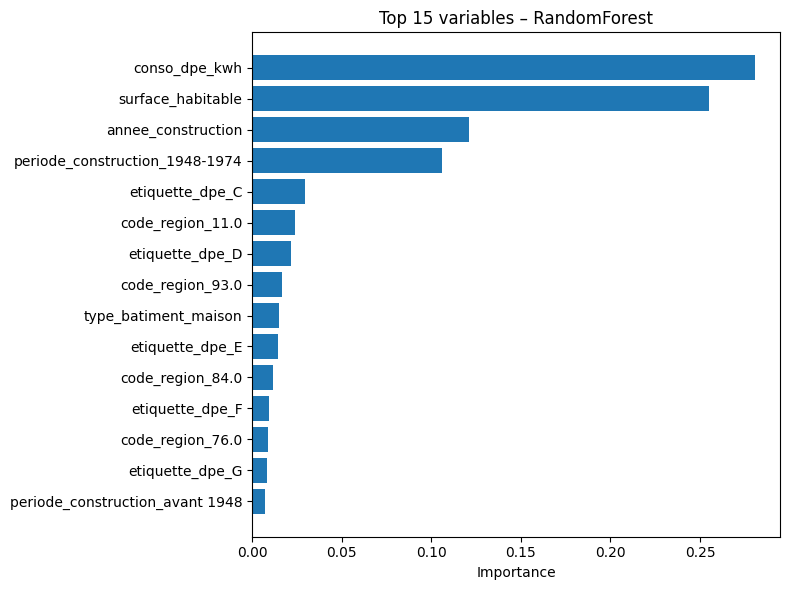

In [ ]:
import matplotlib.pyplot as plt

if hasattr(best_model, "feature_importances_"):
    topN = 15
    plt.figure(figsize=(8, 6))
    plt.barh(feat_imp["feature"].head(topN)[::-1], feat_imp["importance"].head(topN)[::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {topN} variables – {best_name}")
    plt.tight_layout()
    plt.show()